In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import fields
import variogram as vgm

In [11]:
# Analysis variables
timestamps = ["2016-07-01", "2019-08-01"]
tols = [100, 250]
timedeltas = [-1, -2]
space_lags = np.linspace(0, 3.5e3, 15)

timestamp = timestamps[1]
tol = tols[1]
timedelta = timedeltas[0]

# Initial guess for covariance params
vgm_guess = [0.4, 1e3, 0.1]
cross_guess = [1e3, -0.1]

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly_conus.nc")

ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

In [30]:
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


array([[ 1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12.],
       [ 2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
        11.],
       [ 3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10.],
       [ 4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
         9.],
       [ 5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.],
       [ 6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,
         7.],
       [ 7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.],
       [ 8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,
         5.],
       [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,  3.,
         4.],
       [10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,  2.,
         3.],
       [11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,
         2.],
       [12., 11., 10.,  9.,  8.,  7.,  6., 

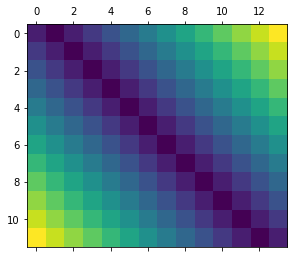

In [32]:
df_1 = mf.field_1.get_spacetime_df()
df_2 = mf.field_2.get_spacetime_df()

D = vgm.distance_matrix_time(np.unique(df_1["time"].values), np.unique(df_2["time"].values))
plt.matshow(D)
D

In [16]:
vario_res = vgm.variogram_analysis(
    mf,
    space_lags,
    tol=tol,
    time_lag=-1,
    crop_lags=True,
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
# Look at the space and time distance matrices for the cross cov
vario_res['xco2:sif']

,lag,xco2:sif,counts
0,0.0,inf,1584.0
1,500.0,-0.223339,8932.0
2,750.0,-0.240752,11176.0
3,1000.0,-0.221141,15510.0
4,1250.0,-0.201225,17424.0
5,1500.0,-0.208942,16654.0
6,1750.0,-0.195693,18194.0
7,2000.0,-0.184390,16368.0
8,2250.0,-0.188902,18876.0
9,2500.0,-0.182050,17292.0


In [10]:
df_vgm

,lag,xco2,xco2_counts,sif,sif_counts
0,0.0,inf,596.0,inf,790.0
1,500.0,6.928041e-01,3413.0,5.774765e+296,4452.0
2,750.0,6.844620e-01,4155.0,9.231270e-01,5573.0
3,1000.0,9.072246e+296,5614.0,7.760448e+296,7730.0
4,1250.0,8.222634e+296,6502.0,7.021665e+296,8682.0
5,1500.0,8.358015e+296,6152.0,6.922444e+296,8300.0
6,1750.0,8.779027e+296,6578.0,7.465427e+296,9066.0
7,2000.0,7.899917e+296,5991.0,7.065946e+296,8159.0
8,2250.0,8.329231e+296,6828.0,7.429751e+296,9411.0
9,2500.0,8.491379e+296,6193.0,7.647449e+296,8621.0


In [ ]:
xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["xco2"], df_vgm["xco2_counts"], vgm_guess)
sif_params, df_vgm["sif_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["sif"], df_vgm["sif_counts"], vgm_guess)

sigmas = [xco2_params[0], sif_params[0]]
cross_params, df_cov["cross_fit"] = vgm.fit_variogram_wls(df_cov["lag"], df_cov["xco2:sif"], df_cov["xco2:sif_counts"], cross_guess, sigmas=sigmas)